In [148]:
import pandas as pd
import numpy as np
from feature_engine.creation import CyclicalFeatures
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from lime import lime_tabular
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer
import plotly.express as px
from xgboost import XGBClassifier
import shap
import pickle
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib as mpl
warnings. filterwarnings('ignore')
random.seed(42)
np.random.seed(42)

In [124]:
df = pd.read_csv('new dataset.csv', parse_dates=['Timestamp'])
df = df.drop('Country', axis=1)

df['Hour'] = df['Timestamp'].dt.hour
cyclic = CyclicalFeatures(variables=None, drop_original=True)
conv = cyclic.fit_transform(df[['Hour']])
df = pd.concat([df, conv], axis=1)

df['Weekend'] = df['Timestamp'].apply(lambda x: x.weekday() >= 5)
df['Weekend'] = df['Weekend'].astype(int)

random_integers = [random.randint(0, 1) for _ in range(len(df))]
df['Introvert'] = random_integers

random_notif = [random.randint(0, 3) for _ in range(len(df))]
df['Ad Location'] = random_notif
replace_notif = {0: 'Push Notif', 1: 'Pop Up', 2: 'Lower Banner', 3: 'Upper Banner'}

df['Ad Location'] = df['Ad Location'].replace(replace_notif)
df['Ad Category'] = None
df['Ad Category'].iloc[df[(df['Age'] >= 40)].index] = 'Finance'                     
df['Ad Category'].iloc[df[(df['Age'] >= 19) & (df['Age'] <= 40) & (df['Male'] == 0) & (df['Introvert'] == 0)].index] = 'Fashion'
df['Ad Category'].iloc[df[(df['Age'] >= 19) & (df['Age'] <= 30) & (df['Male'] == 1) & (df['Introvert'] == 1)].index] = 'Games'
df['Ad Category'].iloc[df[(df['Age'] >= 40)].index] = 'Finance'
df['Ad Category'].iloc[df[(df['Age'] >= 19) & (df['Age'] <= 35) & (df['Hour'] > 12) & (df['Hour'] < 18)].index] = 'Food'
df['Ad Category'].iloc[df[(df['Age'] >= 40) & (df['Age'] <= 50) & (df['Weekend'] == 1) & (df['Area Income'] > df['Area Income'].quantile(0.50))].index] = 'Travel'

choices = ['Finance', 'Fashion', 'Food', 'Games', 'Travel']
probs = [0.45, 0.25, 0.15, 0.08, 0.07]
for i in df[df['Ad Category'].isna()].index:
    df.at[i, 'Ad Category'] = random.choices(choices, probs)[0]

In [125]:
X = df.drop(['Timestamp', 'Clicked on Ad', 'Hour'], axis=1)
X = pd.get_dummies(X, dtype='int')
y = df[['Clicked on Ad']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
df_dashboard = df.iloc[X_train.index]
df_dashboard[['Timestamp', 'Age', 'Male', 'Introvert', 'Continent',  'Area Income', 'Daily Internet Usage', 'Daily Time Spent on Site',
        'Ad Location', 'Ad Category', 'Clicked on Ad']].to_csv('df_dashboard.csv', index=False)

In [ ]:
#df[['Timestamp', 'Age', 'Male', 'Introvert', 'Continent',  'Area Income', 'Daily Internet Usage', 'Daily Time Spent on Site',
#        'Ad Location', 'Ad Category', 'Clicked on Ad']].to_csv('cleaned dataset.csv', index=False)

In [95]:
df_predict = df.iloc[X_test.index]
df_predict[['Timestamp', 'Age', 'Male', 'Introvert', 'Continent',  'Area Income', 'Daily Internet Usage', 'Daily Time Spent on Site',
        'Ad Location', 'Ad Category', 'Clicked on Ad']].to_csv('df_predict.csv', index=False)

In [ ]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
preds = rfc.predict(X_test)
pickle.dump(rfc, open('rfc.pkl', 'wb'))
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

In [35]:
explainer = shap.Explainer(rfc)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values[1], features=X_train, alpha=0.5)

NameError: name 'rfc' is not defined

In [126]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test.values)
#pickle.dump(xgb, open('xgb.pkl', 'wb'))
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       120
           1       0.95      0.95      0.95       130

    accuracy                           0.95       250
   macro avg       0.95      0.95      0.95       250
weighted avg       0.95      0.95      0.95       250

[[114   6]
 [  6 124]]


In [37]:
preds_proba_1 = xgb.predict_proba(X_test.values)[:, 1]
fpr, tpr, _ = roc_curve(y_test, preds_proba_1)
auc = roc_auc_score(y_test, preds_proba_1)

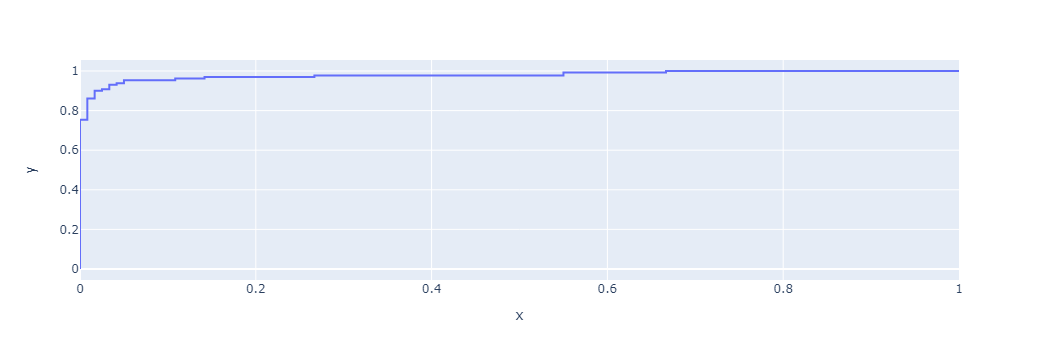

In [93]:
px.line(x=fpr, y=tpr)

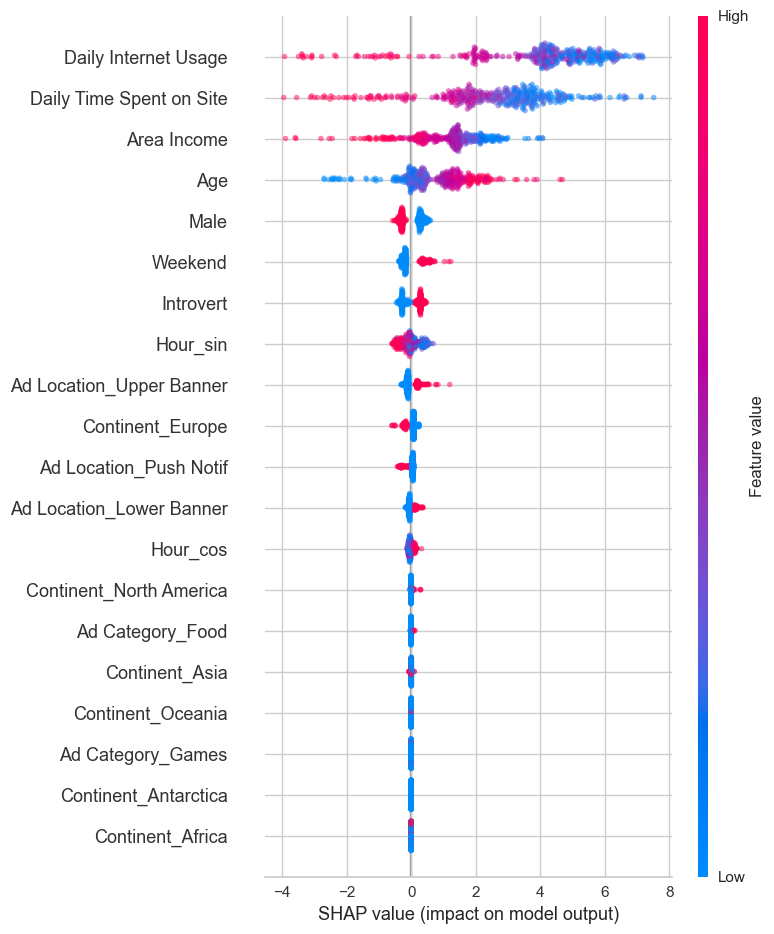

In [127]:
explainer = shap.Explainer(xgb)
shap_values = explainer.shap_values(X_train[pd.concat([X_train, y_train], axis=1)['Clicked on Ad'] == 1])
shap.summary_plot(shap_values, features=X_train[pd.concat([X_train, y_train], axis=1)['Clicked on Ad'] == 1], alpha=0.5)

In [140]:
test2 = X_train[pd.concat([X_train, y_train], axis=1)['Clicked on Ad'] == 1]
# Use the melt function to reshape the DataFrame
melted_df2 = test2.melt(var_name='Category', value_name='Value')

# Sort the DataFrame by the original index to maintain the order
melted_df2 = melted_df2.sort_index()

# Rename the 'Value' column to 'ColumnA'
melted_df2 = melted_df2.rename(columns={'Value': 'Feature Value'})

# Reset the index of the resulting DataFrame
melted_df2 = melted_df2.reset_index(drop=True)

melted_df2 = melted_df2.iloc[::-1].reset_index(drop=True)

In [128]:
test = pd.DataFrame(shap_values, columns=X_train.columns)

In [141]:
# Use the melt function to reshape the DataFrame
melted_df = test.melt(var_name='Category', value_name='Value')

# Sort the DataFrame by the original index to maintain the order
melted_df = melted_df.sort_index()

# Rename the 'Value' column to 'ColumnA'
melted_df = melted_df.rename(columns={'Value': 'SHAP'})

# Reset the index of the resulting DataFrame
melted_df = melted_df.reset_index(drop=True)


In [142]:
melted_df['Feature Value'] = melted_df2['Feature Value']

In [143]:
melted_df

,Category,SHAP,Feature Value
0,Daily Time Spent on Site,2.155038,1.00
1,Daily Time Spent on Site,3.211062,0.00
2,Daily Time Spent on Site,3.806891,0.00
3,Daily Time Spent on Site,3.458578,0.00
4,Daily Time Spent on Site,2.208105,1.00
...,...,...,...
9245,Ad Category_Travel,0.000000,54.96
9246,Ad Category_Travel,0.000000,35.00
9247,Ad Category_Travel,0.000000,40.88
9248,Ad Category_Travel,0.000000,38.96


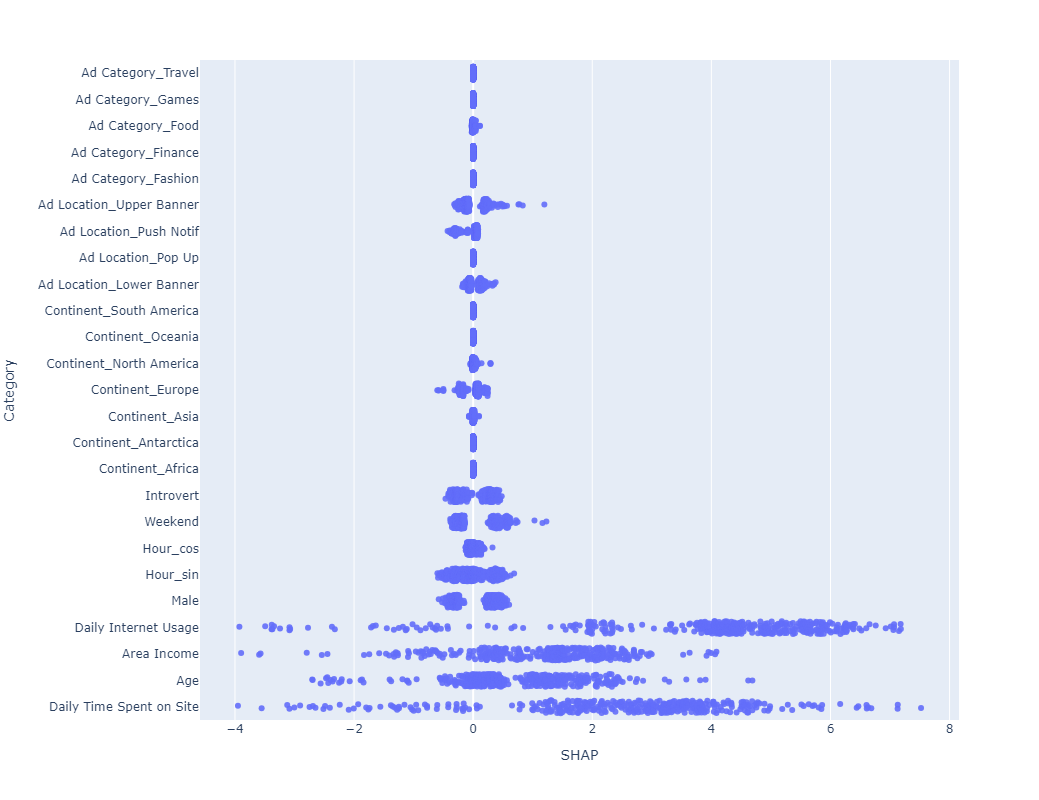

In [153]:
fv = melted_df['Feature Value']
fv_01 = (fv - fv.min()) / (fv.max() - fv.min())
fv_colors = {n: mpl.colors.rgb2hex(c) for n, c in zip(fv, mpl.cm.viridis(fv_01))}
fig = px.strip(melted_df, x="SHAP", y="Category", stripmode='overlay', height=800,  color_discrete_map=fv_colors)
fig.update_traces(marker=dict(opacity=0.9),
                 jitter=1)
fig.update_layout(showlegend=False)
fig.show()

In [158]:
for in range(
    fv = melted_df['Feature Value']
    fv_01 = (fv - fv.min()) / (fv.max() - fv.min())
    fv_colors = {n: mpl.colors.rgb2hex(c) for n, c in zip(fv, mpl.cm.viridis(fv_01))}

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Hour_sin,Hour_cos,Weekend,Introvert,Continent_Africa,...,Continent_South America,Ad Location_Lower Banner,Ad Location_Pop Up,Ad Location_Push Notif,Ad Location_Upper Banner,Ad Category_Fashion,Ad Category_Finance,Ad Category_Food,Ad Category_Games,Ad Category_Travel
82,56.64,38,61652.53,115.91,0,-0.997669,-0.068242,0,1,0,...,0,0,0,0,1,0,1,0,0,0
991,38.96,38,36497.22,140.67,1,-0.942261,-0.334880,0,0,1,...,0,0,0,1,0,1,0,0,0,0
789,40.88,33,48554.45,136.18,1,-0.997669,-0.068242,0,1,0,...,0,0,1,0,0,0,0,1,0,0
519,35.00,40,46033.73,151.25,1,-0.942261,-0.334880,1,0,0,...,0,0,1,0,0,0,1,0,0,0
916,54.96,42,59419.78,113.75,1,0.631088,-0.775711,1,0,1,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,64.88,42,70005.51,129.80,1,-0.269797,0.962917,1,1,1,...,0,0,0,1,0,0,0,0,0,1
466,82.38,35,25603.93,159.60,0,0.269797,0.962917,0,1,0,...,0,0,0,0,1,0,0,0,1,0
270,44.49,53,63100.13,168.00,1,0.997669,-0.068242,1,0,1,...,0,1,0,0,0,0,1,0,0,0
860,91.37,45,51920.49,182.65,1,0.942261,-0.334880,0,1,0,...,0,1,0,0,0,0,1,0,0,0


In [ ]:
df_cluster = pd.concat([X_train, y_train], axis=1)
df_cluster_finance = df_cluster[(df_cluster['Clicked on Ad'] == 1) & (df_cluster['Ad Category_Finance'] == 1)].drop(['Clicked on Ad', 'Ad Category_Finance'], axis=1)
df_cluster_fashion = df_cluster[(df_cluster['Clicked on Ad'] == 1) & (df_cluster['Ad Category_Fashion'] == 1)].drop(['Clicked on Ad', 'Ad Category_Fashion'], axis=1)
df_cluster_food = df_cluster[(df_cluster['Clicked on Ad'] == 1) & (df_cluster['Ad Category_Food'] == 1)].drop(['Clicked on Ad', 'Ad Category_Food'], axis=1)
df_cluster_games = df_cluster[(df_cluster['Clicked on Ad'] == 1) & (df_cluster['Ad Category_Games'] == 1)].drop(['Clicked on Ad', 'Ad Category_Games'], axis=1)
df_cluster_travel = df_cluster[(df_cluster['Clicked on Ad'] == 1) & (df_cluster['Ad Category_Travel'] == 1)].drop(['Clicked on Ad', 'Ad Category_Travel'], axis=1)

In [ ]:
scaler_finance = MinMaxScaler()
k = kelbow_visualizer(KMeans(), scaler.fit_transform(df_cluster_finance), k=(2,10)).elbow_value_
kmeans_finance = KMeans(n_clusters=k)
kmeans_finance.fit(scaler.fit_transform(df_cluster_finance))

In [ ]:
kmeans_finance.labels_

In [ ]:
scaler_fashion = MinMaxScaler()
k = kelbow_visualizer(KMeans(), scaler.fit_transform(df_cluster_fashion), k=(2,10)).elbow_value_
kmeans_fashion = KMeans(n_clusters=k)
kmeans_fashion.fit(scaler.fit_transform(df_cluster_fashion))

In [ ]:
scaler_food = MinMaxScaler()
k = kelbow_visualizer(KMeans(), scaler.fit_transform(df_cluster_food), k=(2,10)).elbow_value_
kmeans_food = KMeans(n_clusters=k)
kmeans_food.fit(scaler.fit_transform(df_cluster_food))

In [ ]:
scaler_games = MinMaxScaler()
k = kelbow_visualizer(KMeans(), scaler.fit_transform(df_cluster_games), k=(2,10)).elbow_value_
kmeans_games = KMeans(n_clusters=k)
kmeans_games.fit(scaler.fit_transform(df_cluster_games))

In [ ]:
pickle.dump(scaler_finance, open('scaler_finance.pkl', 'wb'))
pickle.dump(kmeans_finance, open('kmeans_finance.pkl', 'wb'))
pickle.dump(scaler_fashion, open('scaler_fashion.pkl', 'wb'))
pickle.dump(kmeans_fashion, open('kmeans_fashion.pkl', 'wb'))
pickle.dump(scaler_food, open('scaler_food.pkl', 'wb'))
pickle.dump(kmeans_food, open('kmeans_food.pkl', 'wb'))
pickle.dump(scaler_games, open('scaler_games.pkl', 'wb'))
pickle.dump(kmeans_games, open('kmeans_games.pkl', 'wb'))

In [ ]:
df_cluster_finance['cluster'] = kmeans_finance.labels_

In [ ]:
df_cluster_finance['cluster'].value_counts()

In [5]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

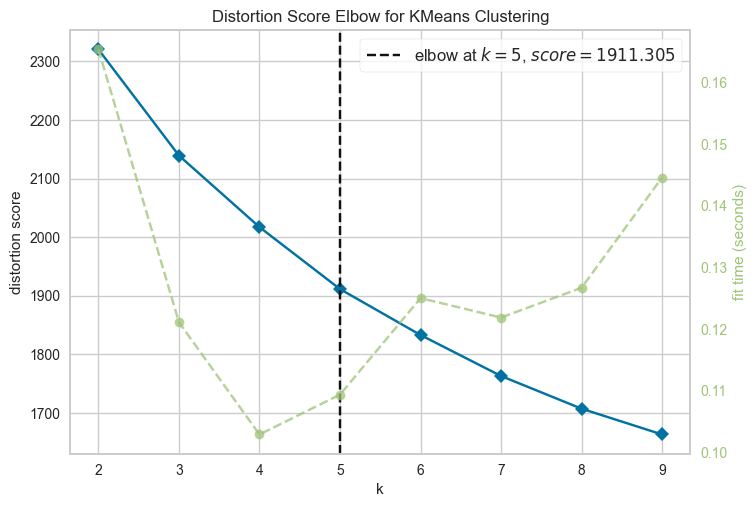

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=9), k=(2, 10))

In [14]:
kelbow_visualizer(KMeans(), X_train_scaled, k=(2,10))

In [15]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_train_scaled)

KMeans(n_clusters=5)

In [29]:
X_train_cluster = X_train.copy()

In [30]:
X_train_cluster

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Hour_sin,Hour_cos,Weekend,Introvert,Continent_Africa,...,Continent_South America,Ad Location_Lower Banner,Ad Location_Pop Up,Ad Location_Push Notif,Ad Location_Upper Banner,Ad Category_Fashion,Ad Category_Finance,Ad Category_Food,Ad Category_Games,Ad Category_Travel
82,56.64,38,61652.53,115.91,0,-9.976688e-01,-0.068242,0,1,0,...,0,0,0,0,1,0,1,0,0,0
991,38.96,38,36497.22,140.67,1,-9.422609e-01,-0.334880,0,0,1,...,0,0,0,1,0,1,0,0,0,0
789,40.88,33,48554.45,136.18,1,-9.976688e-01,-0.068242,0,1,0,...,0,0,1,0,0,0,0,1,0,0
894,85.37,36,66262.59,194.56,1,-9.976688e-01,-0.068242,0,0,0,...,0,0,1,0,0,0,1,0,0,0
398,76.24,40,75524.78,198.32,1,-2.449294e-16,1.000000,0,1,1,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,72.23,25,46557.92,241.03,1,-9.976688e-01,-0.068242,0,1,0,...,0,0,0,1,0,0,0,1,0,0
270,44.49,53,63100.13,168.00,1,9.976688e-01,-0.068242,1,0,1,...,0,1,0,0,0,0,1,0,0,0
860,91.37,45,51920.49,182.65,1,9.422609e-01,-0.334880,0,1,0,...,0,1,0,0,0,0,1,0,0,0
435,56.66,42,72684.44,139.42,0,3.984011e-01,-0.917211,1,1,0,...,0,0,0,0,1,0,0,0,0,1


In [32]:
X_train_cluster['cluster'] = kmeans.labels_

In [34]:
X_train_cluster 

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Hour_sin,Hour_cos,Weekend,Introvert,Continent_Africa,...,Ad Location_Lower Banner,Ad Location_Pop Up,Ad Location_Push Notif,Ad Location_Upper Banner,Ad Category_Fashion,Ad Category_Finance,Ad Category_Food,Ad Category_Games,Ad Category_Travel,cluster
82,56.64,38,61652.53,115.91,0,-9.976688e-01,-0.068242,0,1,0,...,0,0,0,1,0,1,0,0,0,0
991,38.96,38,36497.22,140.67,1,-9.422609e-01,-0.334880,0,0,1,...,0,0,1,0,1,0,0,0,0,2
789,40.88,33,48554.45,136.18,1,-9.976688e-01,-0.068242,0,1,0,...,0,1,0,0,0,0,1,0,0,4
894,85.37,36,66262.59,194.56,1,-9.976688e-01,-0.068242,0,0,0,...,0,1,0,0,0,1,0,0,0,4
398,76.24,40,75524.78,198.32,1,-2.449294e-16,1.000000,0,1,1,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,72.23,25,46557.92,241.03,1,-9.976688e-01,-0.068242,0,1,0,...,0,0,1,0,0,0,1,0,0,2
270,44.49,53,63100.13,168.00,1,9.976688e-01,-0.068242,1,0,1,...,1,0,0,0,0,1,0,0,0,3
860,91.37,45,51920.49,182.65,1,9.422609e-01,-0.334880,0,1,0,...,1,0,0,0,0,1,0,0,0,3
435,56.66,42,72684.44,139.42,0,3.984011e-01,-0.917211,1,1,0,...,0,0,0,1,0,0,0,0,1,0


In [35]:
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [36]:
pickle.dump(kmeans, open('kmeans.pkl', 'wb'))

In [42]:
#X_train.to_csv('df_test_cluster.csv', index=False)

In [53]:
explainer = shap.KernelExplainer(kmeans.predict, X_train_scaled[0:100])
shap_values = explainer.shap_values(X_train_scaled[0:100])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]


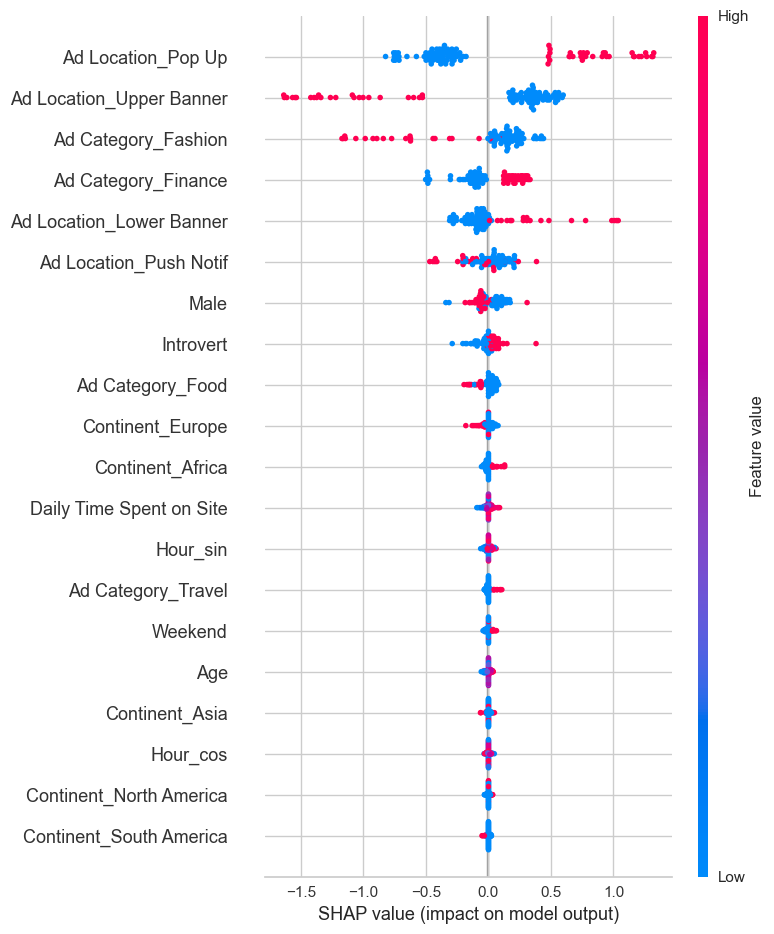

In [55]:
shap.summary_plot(shap_values, X_train_scaled[0:100], feature_names=X_train.columns)

In [68]:
data = shap.kmeans(X_train_scaled, 100)
explainer = shap.KernelExplainer(kmeans.predict, data)
shap_values = explainer.shap_values(X_train_scaled[0:100])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.62s/it]


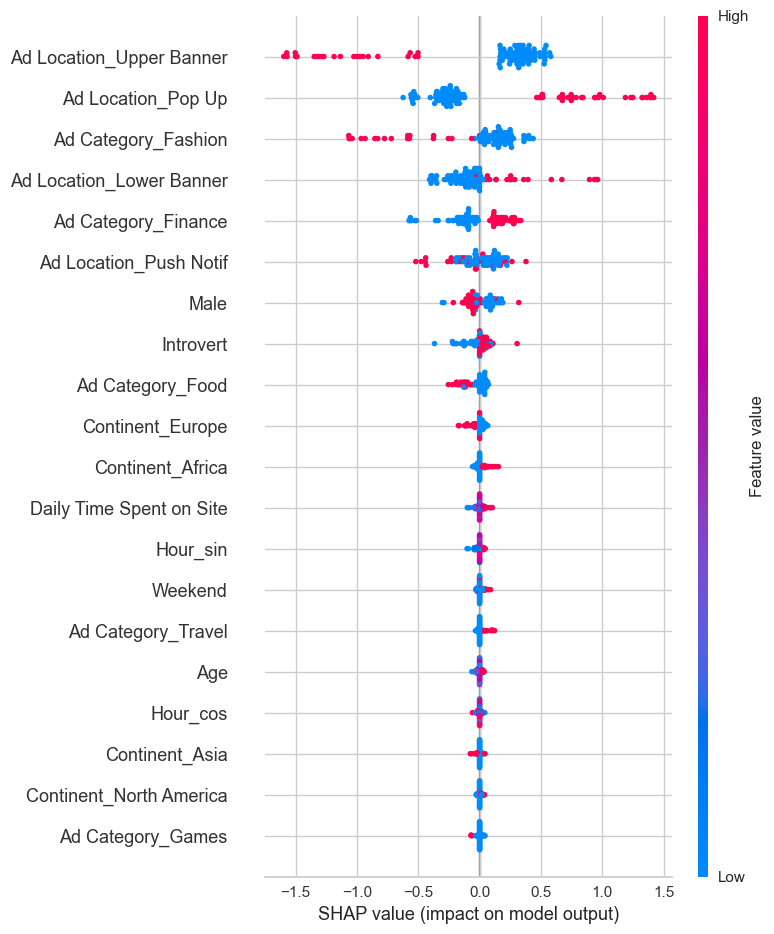

In [70]:
shap.summary_plot(shap_values, X_train_scaled[0:100], feature_names=X_train.columns)

In [71]:
dates = ['All', '2016 January', '2016 February']

In [72]:
dates.index('All')

0

In [14]:
cols = X_train.columns

In [13]:
marketer_variables = ['Hour_sin', 'Hour_cos', 'Weekend', 'Ad Location_Lower Banner', 'Ad Location_Pop Up',
       'Ad Location_Push Notif', 'Ad Location_Upper Banner',
       'Ad Category_Fashion', 'Ad Category_Finance', 'Ad Category_Food',
       'Ad Category_Games', 'Ad Category_Travel']

In [17]:
marketer_index = [5, 6, 7, 16, 17, 18, 19, 20, 21, 22, 23, 24]

In [28]:
hour_sin = Box(low=-1, high=1, shape=(1,), dtype='float')
hour_cos = Box(low=-1, high=1, shape=(1,), dtype='float')
weekend = Discrete(2)
lower_banner = Discrete(2)
pop_up = Discrete(2)
push_notif = Discrete(2)
upper_banner = Discrete(2)
fashion = Discrete(2)
finance = Discrete(2)
food = Discrete(2)
games = Discrete(2)
travel = Discrete(2)

class AdEnv(Env):
    def __init__(self):
        super(AdEnv, self).__init__()
        
        self.action_space = Tuple((hour_sin, hour_cos, weekend, lower_banner, pop_up, push_notif, upper_banner, fashion, finance, food, games, travel))
        self.observation_space = 

In [20]:
from gym import Env
from gym.spaces import MultiDiscrete, Discrete, Box, Tuple
import numpy as np
import matplotlib.pyplot as plt
import random

ModuleNotFoundError: No module named 'gym'

In [21]:
from gym import Env
from gym.spaces import MultiDiscrete, Discrete, Box, Tuple
import numpy as np
import matplotlib.pyplot as plt
import random

class TileEnv(Env):
    def __init__(self):
        super(TileEnv, self).__init__()
        self.tile = [
            np.array([[1,1],
                      [1,1]]),
            np.array([[2,2,2]]),
            np.array([[3,3,3]]).T]

        self.row = random.randint(10,18)
        self.col = random.randint(10,18)
        
        self.action_space = MultiDiscrete([3, self.row, self.col])
        self.observation_space = Box(low=0, high=255, shape=(self.row, self.col), dtype='int');

        self.wall = np.zeros((self.row, self.col), dtype='int')
        self.limits = 100

    def step(self, action):
        tile_idx = action[0]
        x = action[1]
        y = action[2]
        
        if (x + self.tile[tile_idx].shape[0] > self.wall.shape[0]) or (y + self.tile[tile_idx].shape[1] > self.wall.shape[1]):
            reward = 0
        elif np.any(self.wall[x:x+self.tile[tile_idx].shape[0], y:y+self.tile[tile_idx].shape[1]] != 0):
            reward = 0
        else:
            self.wall[x:x+self.tile[tile_idx].shape[0], y:y+self.tile[tile_idx].shape[1]] += self.tile[tile_idx]
            reward = 1

        self.limits = self.limits - 1
        if self.limits <= 0:
            done = True
        else:
            done = False

        info = {}
        return self.wall, reward, done, info

    def reset(self):
        self.wall = np.zeros((self.row,self.col), dtype='int')
        self.limits = 100
        return self.wall

    def render(self):
        plt.imshow(self.wall)
        plt.show()

In [22]:
env = TileEnv()

In [26]:
env.action_space

MultiDiscrete([ 3 12 12])